# Предсказательная модель для телеграм-бота для игры камень-ножницы-бумага (КНБ)

# Описание проекта

## Цель

Пользователь играет с ботом в "камень-ножницы-бумага". Бот должен побеждать как можно чаще. 
<br>Для этого необходимо внедрить в бота модель прогнозирования последующего хода пользователя.
* На входе: последовательность выборов пользователя и бота.
* На выходе: предсказание следующего выбора пользователя.

## Критерии успешности

Будем сравнивать целевую модель с базовой моделью, которая делает выбор случайно, т.е. вероятность выигрыша (vin), проигрыша (loss) или ничьей (draw) одинаковы:
<font size=4><br>$Pbot_{vin}=Pbot_{loss}=Pbot_{draw}=1/3$</font>

**Важно!**
* Если пользователь выберет стратегию случайного выбора, то никакая предсказательная модель не сможет играть эффективнее, в лучшем случае будет паритет. Это можно объяснить здравым смыслом: нельзя предсказать результат, если он случаен и не зависит от предыдущих выборов пользователя. Теоретически это объясняется "равновесием Нэша", [статья по теме](https://habr.com/ru/articles/411523/).
* Также по "равновесию Нэша" получаем, что базовая модель всегда будет играть в ноль, независимо от стратегии пользователя. А вот целевая модель может играть как в плюс, так и в минус, в зависимости от эффективности обучения и стратегии пользователя.
* И, опять же, "по равновесию Нэша", данный проект имеет смысл только в том случае, если пользователь не будет использовать стратегию случайного выбора (возникнет паритет). Будем исходить из того, что пользователь не слышал про "равновесие Нэша" :) А если даже и слышал, то не сможет генерировать по-настоящему случайные последовательности выборов, [статья по теме](http://nabatchikov.com/materials/view/iifmi2017).

**В качестве основного критерия успешности будем использовать бизнес-показатель математическое ожидание:**
<br>Для наглядности представим, что победитель получает **X** рублей, а проигравший теряет **X** рублей
<br>Тогда выигрыш модели - это случайная величина **J**:
<br>J = X, если модель победила
<br>J = -X, если модель проиграла
<br>J = 0, если ничья
<br>Тогда математическое ожидание $M(J) = X * Pbot_{vin} - X * Pbot_{loss} + 0 * Pbot_{draw} = X * (Pbot_{vin} - Pbot_{loss})$

Для удобства примем X = 1, тогда математическое ожидание можно интерпретировать как процент от ставки, который в среднем за раунд будет выигрывать (проигрывать, если матожидание отрицательное) модель, если число игр достаточно велико

На основании вышесказанного,
<br>M(J) = 0, если выборы пользователя случайны
<br>M(J) > 0, если выборы пользователя не случайны и модель хорошо обучается
<br>M(J) < 0, если выборы пользователя не случайны и модель плохо обучается

<u>В качестве критерия успешности модели установим **M(J) = 0.05**</u>


## Варианты обучения бота

Для удобства закодируем признак выбора: камень - 0, ножницы - 1, бумага -2.
Выбор пользователем из (0, 1, 2) будем просто называть действием пользователя

**Вариант 1**: обучение в реальном времени
<br>1) действие пользователя - бот выбирает случайно из (0, 1, 2)
<br>2) действие пользователя - бот "обучается" на результате шага 1 и дает предсказание шага 2
<br>3) действие пользователя - бот "обучается" на результате шагов 1 - 2 и дает предсказание шага 3
<br>4) действие пользователя - бот "обучается" на результате шагов 1 - 3 и дает предсказание шага 4
<br>...
<br>n) действие пользователя - бот "обучается" на результате шагов 1 - (n-1) и дает предсказание шага n

Т.е. на вход модель получает последовательность, состоящую из выборов пользователя и бота.
Получается задача прогнозирования следующего элемента последовательности

**Вариант 2**: обучение на предварительно созданном датасете.
В качестве наблюдений модель получает последовательности выборов пользователя и бота.

**Вариант 3**: совмещение предыдущих подходов. В первых партиях модель прогнозирует ответ, опираясь на знания, полученные обучением на предварительном датасете. И в процессе игры дообучается на данных, полученных от конкретного пользователя


## Выбор моделей

Стоит задача многомерной классификации (3 класса).
<br>Кандидаты:
1. Логистическая регрессия
2. Случайный лес
3. LGBMClassifier
4. RNN

Параметры оценки итоговой модели:
1. Скорость обучения
2. Скорость предсказания
3. Точность предсказания (M(J))

Дополнительно оценим точность модели метрикой F1 ([статья про метрики многоклассовой классификации](https://digitrain.ru/articles/46588/))

# Подготовка библиотек, настройка параметров

In [1]:
# подключаем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import random


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import  roc_auc_score, f1_score, accuracy_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from sklearn.feature_selection import mutual_info_classif, SelectKBest

import copy

from tqdm.notebook import tqdm
import warnings
from sklearn import set_config

In [2]:
# настраиваем параметры
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline
sns.set_style("darkgrid")
warnings.filterwarnings('ignore')
set_config(display="diagram")

# Подготовка данных

## Обучение в реальном времени, по сценарию 1

In [3]:
# Сгенерируем последовательность игр. В каждой игре два признака: выбор пользователя и выбор бота (пользователя 2)
# Необходимо для отладки и прогона кода, в дальнейшем будем обучать на неслучайных массивах
data = np.random.randint(3, size=(10, 2))

In [4]:
# представим данные в табличном виде
df = pd.DataFrame(data, columns=(['user', 'bot']))

На входе имеем информацию о последовательности выборов пользователя и бота.
С учетом этого, можем создать признаки:
1. предыдущие выборы пользователя
2. предыдущие выборы бота
3. мода предыдущих выборов пользователя и бота
4. доля класса 0/1/2 в предыдущих выборах пользователя и бота
5. признак исхода предыдущих партий (победа пользователя, ничья, победа бота)

In [5]:
# создадим функцию по добавлению признаков
def features_maker(df: pd.DataFrame, max_lag: int=10) -> pd.DataFrame:
    df_upd = copy.deepcopy(df)
    
    # зададим функцию определяющую результаты игры
    # 15 - победа пользователя
    # 10 - ничья
    # 5 - победа бота
    def game_result(x):
        if any([(x == [0, 1]).all(), (x == [1, 2]).all(), (x == [2, 0]).all()]):
            return 'user_vin'
        elif any([(x == [0, 0]).all(), (x == [1, 1]).all(), (x == [2, 2]).all()]):
            return 'draw'
        elif any([(x == [1, 0]).all(), (x == [2, 1]).all(), (x == [0, 2]).all()]):
            return 'user_loss'
    
    
    # добавляем циклом выборы и результат предыдущих шагов
    for lag in range(1, max_lag+1):
        df_upd[f'user_lag_{lag}'] = df_upd['user'].shift(lag)
        df_upd[f'bot_lag_{lag}'] = df_upd['bot'].shift(lag)
        df_upd[f'lag_{lag}_result'] = df_upd[[f'user_lag_{lag}', f'bot_lag_{lag}']].apply(lambda x: game_result(x), axis=1)
    
    # определяем названия столбцов с лагом пользователя и бота
    user_lag_columns = df_upd.columns[df_upd.columns.str.contains('user_lag')]
    bot_lag_columns = df_upd.columns[df_upd.columns.str.contains('bot_lag')]
    
    # добавляем первую моду лагов пользователя и бота
    df_upd['user_mode'] = df_upd[user_lag_columns].mode(axis=1)[0]
    df_upd['bot_mode'] = df_upd[bot_lag_columns].mode(axis=1)[0]
    
    # добавляем циклом частоту выборов классов в предыдущих шагах
    for choice in [0, 1, 2]:
        df_upd[f'user_choice_{choice}_share'] = df_upd[user_lag_columns].apply(lambda x: sum(x == choice) / x.count(), axis=1)
        df_upd[f'bot_choice_{choice}_share'] = df_upd[bot_lag_columns].apply(lambda x: sum(x == choice) / x.count(), axis=1)
    
    return df_upd

In [6]:
# добавим признаки
df_upd = features_maker(df, 9)

In [7]:
# удалим первую строку (пока нет информации, боту не на чем предсказывать) 
# сбросим индекс чтобы при кодировке корректно соединить датафреймы
df_upd = df_upd[1:].reset_index(drop=True)

In [8]:
# разделим признаки на X и y
X = df_upd.drop(['user', 'bot'], axis=1)
y = df_upd['user']

In [9]:
# закодируем категориальные признаки OHE

# инициализируем кодировщик
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

# отметим категориальные признаки (все кроме '_share')
category_columns = X.columns[~X.columns.str.contains('share')]

# выполним кодировку
X_ohe = ohe.fit_transform(X[category_columns])
X_ohe = pd.DataFrame(X_ohe, columns=ohe.get_feature_names_out())
X[ohe.get_feature_names_out()] = X_ohe 
X.drop(columns=category_columns, inplace=True)

### Итоговые функции подготовки данных

In [10]:
# соберем функцию, получающую на вход массив результатов игр, дающую на выход X и y
# т.е. объединим все предыдущие шаги

def data_preparation(data: np.array) -> [pd.DataFrame, pd.Series]:
    
    # представим данные в табличном виде
    df = pd.DataFrame(data, columns=(['user', 'bot']))
    
    # добавим признаки, глубину лагов ограничим количеством проведенных игр-1
    df = features_maker(df=df, max_lag=df.shape[0]-1)
    
    # удалим первую строку (пока нет информации, боту не на чем предсказывать) 
    # сбросим индекс чтобы при кодировке корректно соединить датафреймы
    df = df[1:].reset_index(drop=True)
    
    # --- разделим признаки на X и y ---
    X = df.drop(['user', 'bot'], axis=1)
    y = df['user']
    
    return X, y

In [11]:
# для использования в линейных моделях дополнительно добавим функцию OHE
def data_ohe(features: pd.DataFrame, category_columns: list) -> pd.DataFrame:
    
    # создадим копию исходных признаков
    features_duplicate = copy.deepcopy(features)
    
    # инициализируем кодировщик
    ohe = OneHotEncoder(sparse=False, handle_unknown='ignore', drop=None)
    
    # выполним кодировку
    features_ohe = ohe.fit_transform(features_duplicate[category_columns])
    
    # добавим новые названия закодированых столбцов
    features_ohe = pd.DataFrame(features_ohe, columns=ohe.get_feature_names_out())
    
    # добавим закодированые столбцы к остальным столбцам
    features_duplicate[ohe.get_feature_names_out()] = features_ohe
    
    # удалим старые столбцы до кодировки
    features_duplicate.drop(columns=category_columns, inplace=True)
    
    return features_duplicate

In [12]:
# для использования в моделя на основе деревьев добавим функцию порядкового кодирования OE
def data_oe(features: pd.DataFrame, category_columns: list) -> pd.DataFrame:
    
    # создадим копию исходных признаков
    features_duplicate = copy.deepcopy(features)
    
    # инициализируем кодировщик
    oe = OrdinalEncoder(encoded_missing_value=-1)
    
    # выполним кодировку
    features_oe = oe.fit_transform(features_duplicate[category_columns])
    
    # заменим старые столбцы новыми
    features_duplicate[category_columns] = features_oe
    
    return features_duplicate

# Моделирование

## Подбор модели логистической регрессии

Зададим неслучайный массив результатов игр
<br>Т.к. каждый последующий выбор пользователя зависит от результатоы предыдущих игр, максимально правдоподобный массив можно получить только путем игры
<br>Первый массив создадим так: будем делать поочереди выбор за пользователя и за бота с учетом предыдущих выборов каждого
<br>На этом массиве подберем гиперпараметры и первые тесты. В дальнейшем модель будет обучаться на реальных данных в процессе игры

In [13]:
data_first = [[0, 0],
              [0, 1],
              [1, 2],
              [1, 0],
              [1, 0],
              [2, 1],
              [0, 2],
              [1, 0],
              [1, 0],
              [2, 2],
              [2, 2],
              [2, 1],
              [2, 1],
              [2, 1],
              [0, 1],
              [0, 2],
              [0, 2],
              [1, 2],
              [1, 2],
              [1, 0],
              [1, 0],
              [1, 0],
              [2, 0],
              [2, 1],
              [2, 1],
              [2, 1]]

### Формирование модели

In [14]:
# зададим функцию, выдающую предсказание следующего шага на основе предыдущих
# LogisticRegression
def next_step_log_reg_predictor(data: list[list], random_first_steps: int=4, best_features='all', regularization: float=1.0) -> int:
    '''
    на входе: 
    - последовательность выборов пользователя и бота в формате [[user, bot], ...]
    - количество первых шагов, для которых будет использоваться стратегия случайного прогноза (min=4)
    на выходе:
    - предсказание следующего выбора пользователя
    '''
    
    # создадим копию исходных данных
    data_copy = copy.deepcopy(data)
    
    # если данных для предсказания мало, выбор генерируется случайно
    if len(data_copy) < random_first_steps:
        return random.randint(0, 2)
    else:
    
        # добавляем пустую пару выборов для предсказания
        data_copy.append([None, None])

        # подготовка признаков: создание новых признаков, разделение на X и y
        X, y = data_preparation(data_copy)

        # кодируем признаки
        X = data_ohe(X, category_columns=X.columns[~X.columns.str.contains('share')])

        # отберем лучшие признаки (работает только при количестве наблюдений 4+
        if len(data_copy) >= 4:
            feature_selector = SelectKBest(mutual_info_classif, k=best_features)
            # фитуем за исключением последнего наблюдения, т.к. так нулы у целевого признака
            feature_selector.fit(X[:-1], y[:-1])
            X = feature_selector.transform(X)
        else:
            pass

        # инициализируем модель
        clf = LogisticRegression(random_state=123, 
                                 penalty='l2', 
                                 dual=False, 
                                 C=regularization, 
                                 solver='liblinear', 
                                 multi_class='auto',
                                 verbose=0,
                                 warm_start=False,
                                 n_jobs=-1)

        # обучим модель на всех наблюдениях, кроме последнего
        clf.fit(X[:-1], y[:-1])

        # предскажем следующий выбор
        prediction = int(clf.predict(X[-1:])[0])

        return prediction

### Симуляция работы модели

In [15]:
# зададим функцию контр-выбора для победы
def vin_choice(user_choice: int) -> int:
    '''
    0 - камень --> 2 
    1 - ножницы --> 0
    2 - бумага --> 1
    '''
    if user_choice == 0:
        return 2
    elif user_choice == 1:
        return 0
    elif user_choice == 2:
        return 1
    else:
        return 'invalid input'
    

In [16]:
# зададим функцию определения победителя
def vinner(user_bot_choice: list) -> int:
    dict_bot_vins = {1: [[0, 2], [1, 0], [2, 1]],
                     0: [[0, 0], [1, 1], [2, 2]],
                     -1: [[2, 0], [0, 1], [1, 2]]}
    for key in dict_bot_vins:
        if user_bot_choice in dict_bot_vins[key]:
            return key
    

In [17]:
# напишем функцию, симулирующую реальную игру пользователя с ботом через телеграм приложение
# упростим, предположив, что выборы пользователя не зависят от предыдущих выборов бота
def game_simulation(data: list, random_first_steps=4, best_features=20, regularization=1.0):
    '''
    на входе:
    - последовательность выборов пользователя
    на выходе:
    - последовательность выборов пользователя
    - последовательность предсказаний выборов пользователя
    - последовательность выборов бота
    '''
    
    games_choices = []
    games_results = []

    for user_choice in data:
        
        # делаем предсказание бота
        user_choice_prediction = next_step_log_reg_predictor(games_choices, random_first_steps, best_features, regularization)
        # делаем выбор бота
        bot_choice = vin_choice(user_choice_prediction)
        
        # заполняем результаты выборов и заносим в games_choices
        round_choices = [user_choice, bot_choice]
        games_choices.append(round_choices)
        
        # заполняем статистику игры и заносим в games_results
        bot_vin = vinner(round_choices)
        round_results = [user_choice, user_choice_prediction, bot_choice, bot_vin]
        games_results.append(round_results)
    
    return pd.DataFrame(games_results, columns=['user_choice', 'user_choice_prediction', 'bot_choice', 'bot_vin'])

In [18]:
# # проведем симуляцию
# results = game_simulation(np.array(data_first)[:, 0])
# results.head()

### Оценка модели

#### Расчет показателей целевой модели

In [19]:
# на основе статистики рассчитаем интересующие нас показатели
# M(J) математическое ожидание бота
# Частота и точность угадывания классов
# F1

def key_scores(results: pd.DataFrame):
    
    results['flag_guessed'] = results['user_choice'] == results['user_choice_prediction']
    
    # рассчитаем математическое ожидание бота
    m_j = results['bot_vin'].mean()
    
    # рассчитаем частоту и точность угадывания классов
    class_predictions = results.groupby('user_choice')['flag_guessed'].agg(['count', 'mean']).reset_index()
    class_predictions['count'] = round(class_predictions['count'] / class_predictions['count'].sum(), 2)
    class_predictions.columns = ['class', 'class_frequency', 'prediction_probability']
    # подставим вместо идентификаторов классов их значения
    class_dict = {0: 'rock', 1: 'scissors', 2: 'paper'}
    class_predictions['class'] = class_predictions['class'].map(class_dict)
    
    # рассчитаем F1
    f1 = f1_score(results['user_choice'], results['user_choice_prediction'], average='micro')
    
    return class_predictions, m_j, f1    

In [20]:
# Напишем функцию, отображающую динамику изменения показателей от количества сыгранных игр
def dinamic_metrics(results: pd.DataFrame):
    
    dinamic_m_j = pd.DataFrame(columns=['games_cnt', 'm_j'])
    dinamic_f1 = pd.DataFrame(columns=['games_cnt', 'f1'])
    dinamic_class_predictions = pd.DataFrame(columns=['class', 'class_frequency', 'prediction_probability', 'games_cnt'])
    
    for i in range(1, len(results)+1):
        
        # вычисляем метрики по заданному количеству сыгранных игр
        class_predictions, m_j, f1 = key_scores(results[:i])
        
        # добавляем инфо по m_j
        dinamic_m_j.loc[len(dinamic_m_j.index)] = [i, m_j]
        
        # добавляем инфо по f1
        dinamic_f1.loc[len(dinamic_f1.index)] = [i, f1]
        
        # добавляем инфо частоте и точности угадывания классов
        class_predictions['games_cnt'] = i
        dinamic_class_predictions = pd.concat([dinamic_class_predictions, class_predictions])
    
    # меняем типы для удобства
    dinamic_m_j['games_cnt'] = dinamic_m_j['games_cnt'].astype(int)
    dinamic_f1['games_cnt'] = dinamic_f1['games_cnt'].astype(int)
    dinamic_class_predictions['games_cnt'] = dinamic_class_predictions['games_cnt'].astype(int)
    
    return dinamic_m_j, dinamic_f1, dinamic_class_predictions
    

Так как модель первые несколько выборов делает случайно, то обучается каждый раз по-разному. Поэтому при оценке метрик модели воспользуемся техникой bootstrap - будем смотреть усредненные метрики и значения на границах 95% доверительного интервала

In [21]:
# единичный расчет метрик модели
# использовать в случае, если модель обучает неслучайно (нет случайных выборов при инициализации)
# dinamic_m_j, dinamic_f1, dinamic_class_predictions = dinamic_metrics(game_simulation(np.array(data_first)[:, 0]))

In [22]:
# функция расчета метрик целевой модели с использованием bootstrap
def target_model_metrics_ci(data, bootstrap_steps=10, random_first_steps=4, best_features=20, regularization=1.0):
    dinamic_m_j_bootstrap = []
    dinamic_f1_bootstrap = []
    for i in tqdm(range(0, bootstrap_steps)):
        dinamic_m_j, dinamic_f1, dinamic_class_predictions = dinamic_metrics(game_simulation(data, random_first_steps, best_features, regularization))
        dinamic_m_j_bootstrap.append(list(dinamic_m_j['m_j']))
        dinamic_f1_bootstrap.append(list(dinamic_f1['f1']))

    # переведем в numpy массивы для удобства расчетов
    dinamic_m_j_bootstrap = np.array(dinamic_m_j_bootstrap)
    dinamic_f1_bootstrap = np.array(dinamic_f1_bootstrap)

    # рассчитаем среднее значение f1 и m_j и границы доверительного интервала
    dinamic_m_j_data = pd.DataFrame(columns=['games_cnt', 'm_j_avg', 'm_j_ci_0', 'm_j_ci_025', 'm_j_ci_975', 'm_j_ci_100'])
    dinamic_f1_data = pd.DataFrame(columns=['games_cnt', 'f1_avg', 'f1_ci_0', 'f1_ci_025', 'f1_ci_975', 'f1_ci_100'])

    for i in range(dinamic_m_j_bootstrap.shape[1]):

        # выбираем массив со всеми получившимися f1 и m_j для заданного количества игр
        m_j_array = dinamic_m_j_bootstrap[:, i]
        f1_array = dinamic_f1_bootstrap[:, i]

        # считаем показатели m_j
        m_j_avg = m_j_array.mean()
        m_j_ci_0 = np.quantile(m_j_array, 0)
        m_j_ci_025 = np.quantile(m_j_array, 0.25)
        m_j_ci_975 = np.quantile(m_j_array, 0.975)
        m_j_ci_100 = np.quantile(m_j_array, 1)

        # считаем показатели f1
        f1_avg = f1_array.mean()
        f1_ci_0 = np.quantile(f1_array, 0)
        f1_ci_025 = np.quantile(f1_array, 0.25)
        f1_ci_975 = np.quantile(f1_array, 0.975)
        f1_ci_100 = np.quantile(f1_array, 1)

        # добавляем инфо по показателям в таблицу
        dinamic_m_j_data.loc[len(dinamic_m_j_data.index)] = [i+1, m_j_avg, m_j_ci_0, m_j_ci_025, m_j_ci_975, m_j_ci_100]
        dinamic_f1_data.loc[len(dinamic_f1_data.index)] = [i+1, f1_avg, f1_ci_0, f1_ci_025, f1_ci_975, f1_ci_100]
    return dinamic_m_j_data, dinamic_f1_data

In [23]:
dinamic_m_j_data, dinamic_f1_data = target_model_metrics_ci(data=np.array(data_first)[:, 0],
                                                            bootstrap_steps=100,
                                                            random_first_steps=4,
                                                            best_features=20, 
                                                            regularization=1.0)

  0%|          | 0/100 [00:00<?, ?it/s]

In [24]:
# зададим функцию отображения динамики по m_j
def plot_m_j(data):
    
    fig = plt.figure(figsize=(10, 5))
    plt.title('Анализ математического ожидания модели', fontsize=20)
    plt.ylabel('Математическое ожидание', size=12)
    plt.xlabel('Количество сыгранных игр', size=12)

    plt.plot(data['games_cnt'], data['m_j_avg'], color='black', linestyle='-', linewidth=2, label='Среднее значение Мат.ожидания целевой модели')
    # plt.plot(dinamic_m_j['games_cnt'], dinamic_m_j['m_j_ci_025'], color='black', linestyle='-', linewidth=2, label='Мат.ожидание модели')
    # plt.plot(dinamic_m_j['games_cnt'], dinamic_m_j['m_j_ci_975'], color='black', linestyle='-', linewidth=2, label='Мат.ожидание модели')
    
    plt.fill_between(data['games_cnt'], data['m_j_ci_025'], data['m_j_ci_975'], color='black', alpha=0.1, label='95% доверительный интервал целевой модели')
    
    # plt.fill_between(data['games_cnt'], data['m_j_ci_0'], data['m_j_ci_025'], color='red', alpha=0.1, label='5% оставшихся значений целевой модели')
    # plt.fill_between(data['games_cnt'], data['m_j_ci_975'], data['m_j_ci_100'], color='red', alpha=0.1)
    
    
    plt.hlines(0.05, 1, len(data), color = 'r', linestyle = '--', linewidth=2, label='Мат.ожидание 5%')
    
    plt.legend(loc='upper right', prop={'size': 12})
    plt.xlim(left=1)
    plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(1, decimals=0))

    # plt.xticks(rotation=0)
    plt.xticks(range(1, len(data)+1, 1))

    plt.tight_layout()
    plt.show()


In [25]:
# зададим функцию отображения динамики по f1
def plot_f1(data):

    # fig = plt.figure(figsize=(10, 3))
    # plt.title('Изменение метрики F1 в зависимости от сыгранных игр')
    # plt.ylabel('F1', size=12)
    # plt.xlabel('Количество сыгранных игр', size=12)

    plt.plot(data['games_cnt'], data['f1_avg'], color='black', linestyle='-', linewidth=2, label='Среднее значение F1 целевой модели')
    
    plt.fill_between(data['games_cnt'], data['f1_ci_025'], data['f1_ci_975'], color='black', alpha=0.1, label='95% доверительный интервал целевой модели')
    
    # plt.fill_between(data['games_cnt'], data['f1_ci_0'], data['f1_ci_025'], color='red', alpha=0.1, label='5% оставшихся значений целевой модели')
    # plt.fill_between(data['games_cnt'], data['f1_ci_975'], data['f1_ci_100'], color='red', alpha=0.1)
    
    # ax = sns.lineplot(data=dinamic_f1, x=dinamic_f1['games_cnt'], y='f1', color='black')
    # ax.hlines(0, 1, len(dinamic_f1), color = 'r', linestyle = ':')

    # plt.xlim(left=1)
    # ax.yaxis.set_major_formatter(mticker.PercentFormatter(1, decimals=0))

    # plt.xticks(rotation=0)
    # plt.xticks(range(1, len(dinamic_f1)+1, 1))

    # plt.tight_layout()
    # plt.show()

In [26]:
# неактуально при расчете доверительного интервала, можно использовать, когда модель будет полностью детерминирована (без случайных выборов на первых шагах)
# # зададим функцию отображения динамики по частоте и точности угадывания классов
# def plot_classes(dinamic_class_predictions):

#     fig = plt.figure(figsize=(10, 6))

#     # строим график с вероятностями угадать класс
#     fig.add_subplot(2, 1, 1)
#     plt.title('Анализ классов: вероятность определения', fontsize=20)
#     plt.ylabel('Вероятность угадывания', size=12)
#     plt.xlabel('Количество сыгранных игр', size=12)

#     ax = sns.lineplot(data=dinamic_class_predictions, x=dinamic_class_predictions['games_cnt'], y='prediction_probability', hue='class', palette='Set1')
    
#     plt.xticks(range(1, dinamic_class_predictions['games_cnt'].max()+1, 1))
#     plt.xlim(left=1)
#     ax.yaxis.set_major_formatter(mticker.PercentFormatter(1, decimals=0))
#     # ax.get_xaxis().set_visible(False)

#     # ------------------------------------------------------------------------

#     # строим график с частотами классов
#     fig.add_subplot(2, 1, 2)
#     plt.title('Анализ классов: распределение', fontsize=20)

#     ax = sns.barplot(data=dinamic_class_predictions, x=dinamic_class_predictions['games_cnt'], y='class_frequency', hue='class', dodge=True, saturation=0.75, palette='Set1')
#     # ax.get_legend().remove()

#     plt.xlim(left=0)
#     plt.xlim(right=dinamic_class_predictions['games_cnt'].max())
#     ax.yaxis.set_major_formatter(mticker.PercentFormatter(1, decimals=0))

#     plt.ylabel('Доля класса', size=12)
#     plt.xlabel('Количество сыгранных игр', size=12)

#     plt.tight_layout()
#     plt.show()

#### Сравнение с показателями базовой модели

Применим bootstrap для определения доверительного интервала метрики F1 базовой модели

In [27]:
# Напишем функцию
# применим технику BOOTSTRAP: n раз сгенерируем случайные ответы бота
# рассчитаем среднее значение метрики F1
# и границы доверительного интервала 95%
# в зависимости от количества игр
# и отобразим все на графике
def f1_random_bootstrap(user_choices: list, bootstrap_steps: int=100) -> np.array:
    f1_matrix = []

    for i in range(bootstrap_steps):
        bot_choices = np.random.randint(3, size=len(user_choices))
        f1_array = []

        for k in range(1, len(bot_choices)+1):
            f1 = f1_score(user_choices[:k], bot_choices[:k], average='micro')
            f1_array.append(f1)

        f1_matrix.append(f1_array)
    f1_matrix = np.array(f1_matrix)
    
    # рассчитаем среднее значение f1 и границы доверительного интервала
    data_bootstrap_f1 = pd.DataFrame(columns=['games_cnt', 'f1_avg', 'f1_ci_0', 'f1_ci_025', 'f1_ci_95',  'f1_ci_975', 'f1_ci_100'])
    for i in range(f1_matrix.shape[1]):
        # выбираем массив со всеми получившимися f1 для заданного количества игр
        f1_array = f1_matrix[:, i]
        # считаем показатели
        f1_avg = f1_array.mean()
        f1_ci_0 = np.quantile(f1_array, 0)
        f1_ci_025 = np.quantile(f1_array, 0.25)
        f1_ci_95 = np.quantile(f1_array, 0.95)
        f1_ci_975 = np.quantile(f1_array, 0.975)
        f1_ci_100 = np.quantile(f1_array, 1)
        # добавляем инфо по показателям в таблицу
        data_bootstrap_f1.loc[len(data_bootstrap_f1.index)] = [i+1, f1_avg, f1_ci_0, f1_ci_025, f1_ci_95, f1_ci_975, f1_ci_100]
    
    return data_bootstrap_f1

In [28]:
# сохраним табличные результаты bootstrep в переменную
data_bootstrap_f1 = f1_random_bootstrap(np.array(data_first)[:, 0], 1000)

In [29]:
# зададим функцю построения среднего и доверительного интервала f1, полученных bootstrap для случайной модели
def plot_f1_botstrap_ci(data_bootstrap_f1):

    # fig = plt.figure(figsize=(10, 3))

    # plt.title('Доверительный интервал метрики F1 в зависимости от количества игр')
    # plt.ylabel('F1', size=12)
    # plt.xlabel('Количество сыгранных игр', size=12)

    plt.plot(data_bootstrap_f1['games_cnt'], data_bootstrap_f1['f1_avg'], color='red', linestyle='--', linewidth=2, label='Среднее значение F1 случайной модели')
    # plt.plot(data_bootstrap_f1['games_cnt'], data_bootstrap_f1['f1_ci_0'], color='red', linestyle='--', linewidth=1)
    # plt.plot(data_bootstrap_f1['games_cnt'], data_bootstrap_f1['f1_ci_95'], color='red', linestyle='--', linewidth=1)
    # plt.legend(loc='upper right')

    plt.fill_between(data_bootstrap_f1['games_cnt'], data_bootstrap_f1['f1_ci_025'], data_bootstrap_f1['f1_ci_975'], color='red', alpha=0.1, label='95% доверительный интервал случайной модели')
    # plt.fill_between(data_bootstrap_f1['games_cnt'], data_bootstrap_f1['f1_ci_95'], data_bootstrap_f1['f1_ci_100'], color='black', alpha=0.1, label='P-value 5%')

    # plt.xlim(left=1)
    # plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(1, decimals=0))

    # plt.xticks(rotation=0)
    # plt.xticks(range(1, len(data_bootstrap_f1)+1, 1))

    # plt.tight_layout()
    # plt.show()

#### Результаты

Нам необходимо проверить два утверждения 

<br>**Касательно метрики F1**
<br>Хотим проверить, что целевая модель имеет лучшую точность, чем базовая, для этого сформулируем гипотезы:
* Нулевая гипотеза ($H_0$) - среднее значение F1 базовой модели равно среднему значению F1 целевой модели
* Алтернативная гипотеза ($H_1$) - среднее значение F1 базовой модели не равно среднему значению F1 целевой модели
* Двусторонний тест, $Pvalue = 5\%$

<br>**Касательно метрики Математическое ожидание:**
<br>Хотим проверить, что выполняется заданный в начале проекта критерий успешности - математическое ожидание не менее 5%, для этого сформулируем гипотезы:
* Нулевая гипотеза ($H_0$) - среднее значение Математического ожидания целевой модели равно 5%
* Алтернативная гипотеза ($H_1$) - среднее значение Математического ожидания целевой модели не равно 5%
* Двусторонний тест, $Pvalue = 5\%$


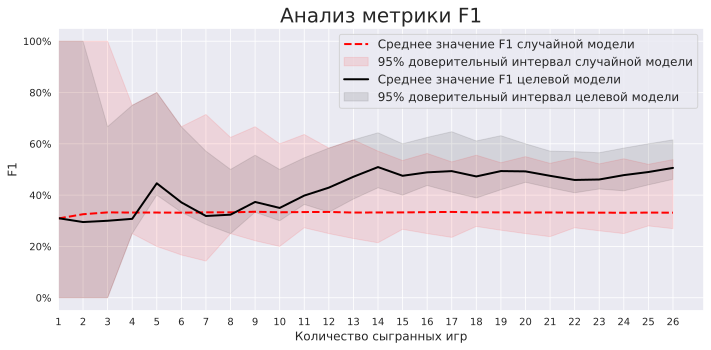

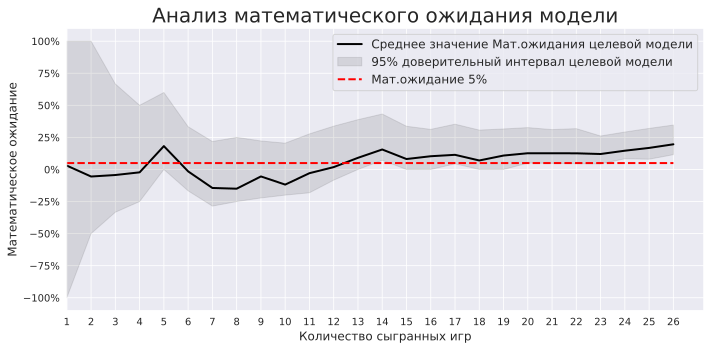

In [30]:
# выведем всю необходимую информацию на графиках

# ------------ анализ метрики F1 ------------
fig = plt.figure(figsize=(10, 5))
plt.title('Анализ метрики F1', fontsize=20)
plt.ylabel('F1', size=12)
plt.xlabel('Количество сыгранных игр', size=12)

# функции построения графиков
plot_f1_botstrap_ci(data_bootstrap_f1)
plot_f1(dinamic_f1_data)

plt.legend(loc='upper right', prop={'size': 12})
plt.xlim(left=1)
plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(1, decimals=0))

plt.xticks(rotation=0)
plt.xticks(range(1, len(dinamic_f1_data)+1, 1))

plt.tight_layout()
plt.show()

# ------------ анализ метрики M(J) ------------
plot_m_j(dinamic_m_j_data)

# ------------ анализ распределения классов ------------
# plot_classes(dinamic_class_predictions)


### Выводы

**На базе логистической регрессии подготовлена модель, способная обыгрывать пользователя при игре в камень-ножницы-бумага:** 
<br>Процесс обучения модели:
* Обучение в режиме реального времени
* Для обучения используются данные о выборах, сделанных пользователем в предыдущих играх
* Несколько первых выборов модель делает случайным образом, за неимением данных

<br>Оценка качества модели:
* В качестве базовой модели для сравнения использовали базовую модель, делающую выборы с равной вероятностью
* Начиная с 11 партии в игру, нулевая гипотеза (F1 целевой модели == F1 базовой модели) стабильно отклоняется. F1 целевой модели колеблется от 40% до 50%. F1 базовой модели 33%
* Начиная с 13 шага математическое ожидание целевой модели выше 5%, а с 24 шага начинает отклоняться нулевая гипотеза о равенстве мат.ожидания модели 5%
* Можно говорить о том, что статистически значимой эффективности модель достигает к 13й партии игры. Под эффективностью подразумеваем способность выигрывать чаще, чем проигрывать

<br>Что еще можно попробовать сделать в рамках данной модели:
* Теоретически вывести статистически значимое количество партий для оценки гипотез
* Для снижения количества игр, необходимых для эффективной работы модели: 
  * Реализовать обучение на исторических данных с другими пользователями. Т.е подавать на вход серии последовательностей выборов разных пользователей
  * При обучении на исторических данных, добавить признак пользователя, чтобы модель предсказывала с учетом ранее имевшегося опыта с конкретным пользователем
* Реализовать сбор реальных последовательностей выборов пользователей и выполнить проверку гипотез на обогащенных данных
* Оценить важность используемых признаков, подобрать оптимальное количество (по умолчанию берем 20 лучших признаков)

**Планы по развитию/доработке проекта:**
* Имплементировать модель в телеграмм-бот и организовать сбор статистики
* Подготовить и проанализировать модели на базе дерева решений по методам бэггинга и бустинга: RandomForestClassifier, LGBMClassifier
* Также опробовать модель RNN
* Ввести дополнительную метрику времени обучения/предсказания, составить сравнительную таблицу моделей по всем использовавшимся метрикам и выбрать наилучшую модель для нашей задачи
* Попробовать новые подходы в обучении (на исторических данных, гибридное)